# Similarity Study: load saved graphs , calculate similarity, comapre similarities 


https://tel.archives-ouvertes.fr/tel-00378201/document

In [1]:
from __future__ import print_function

import os
import sys

import numpy as np
import pandas as pd

import SPARQLWrapper

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import MonaLIA library from the package in the MonaLIA 2.0 project
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib 
from MonaLIA.util import metadata_helpers as metadata

importlib.reload(metadata)

<module 'MonaLIA.util.metadata_helpers' from 'C:\\Users\\abobashe\\Documents\\MonaLIA\\MonaLIA\\util\\metadata_helpers.py'>

In [101]:
print('SPARQLWrapper ver.', SPARQLWrapper.__version__)
print('Pandas ver.', pd.__version__)

SPARQLWrapper ver. 1.8.5
Pandas ver. 1.1.1


In [102]:
wds_Joconde_Corese = 'http://localhost:8080/sparql'

In [290]:
from SPARQLWrapper import SPARQLWrapper, JSON, XML

test = '''
select * where { bind (2.84217e-15 as ?e)}
'''

sparql = SPARQLWrapper(wds_Joconde_Corese)
sparql.setQuery(test)
sparql.setReturnFormat(JSON)
result = sparql.query()

print(result.response.read().decode('utf-8'))


{
"head": { 
"vars": [
"e"] },
"results": { "bindings": [
{
"e": { "type": "typed-literal", "datatype": "http://www.w3.org/2001/XMLSchema#double", "value": "2,8422e-15"}
}
] }
}



### Create subfolder in the CORESE web service temp data directory and copy the graph files
NOTE: (1) CORESE is a web service and can only access the files in the subfolders (2) on the launch the server creates a temp folder for the webservice to run  (2) relaunching of CORESE server resets the entire temp directory

In [291]:
import tempfile
import getpass
import shutil
import os

service_data_path = os.path.join(tempfile.gettempdir(),
                     getpass.getuser(),
                     "webapp", "data", "similarity")
graph_location_path = os.path.join(os.path.expanduser("~"), "Documents", "MonaLIA", "Joconde", "similarity")

if os.path.exists(service_data_path):
    shutil.rmtree(service_data_path)
    
shutil.copytree(graph_location_path, service_data_path)

'C:\\Users\\abobashe\\AppData\\Local\\Temp\\abobashe\\webapp\\data\\similarity'

### Load DBPedia subgraph to CORESE server from the saved Turtle file

In [292]:
dbp_graph_name = 'DBPedia_unrooted'

In [293]:
read_saved_dbpedia_graph = '''
prefix ml: <http://ns.inria.fr/monalia/>
prefix xt: <http://ns.inria.fr/sparql-extension/>

select *  where {
     bind (xt:load(<http://localhost:8080/data/similarity/%s.ttl>) as ?g2)
     bind (xt:focus(?g2, xt:sparql("select * where {}")) as ?sp)
     bind (xt:namedgraph(ml:%s, ?g2) as ?t2)
}
''' % (dbp_graph_name, dbp_graph_name)

In [294]:
%time metadata.sparql_service_update(wds_Joconde_Corese, read_saved_dbpedia_graph)

Wall time: 86.2 ms


'Done'

### Query just created DBPedia subgraph 

In [295]:
query_dbp_subgraph = '''
prefix ml: <http://ns.inria.fr/monalia/>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 

select ?sub_category ?parent_category ?sub_category_label ?parent_category_label
where {
     graph ml:%s{
       ?sub_category rdfs:subClassOf ?parent_category ;
                     skos:prefLabel ?sub_category_label.
       optional {?parent_category skos:prefLabel ?parent_category_label.}     
       }
}
order by 
?sub_category ?parent_category

''' % (dbp_graph_name)



In [296]:
%time dbp_subgraph_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_dbp_subgraph)
print(dbp_subgraph_df.shape)

Wall time: 66.2 ms
(1444, 4)


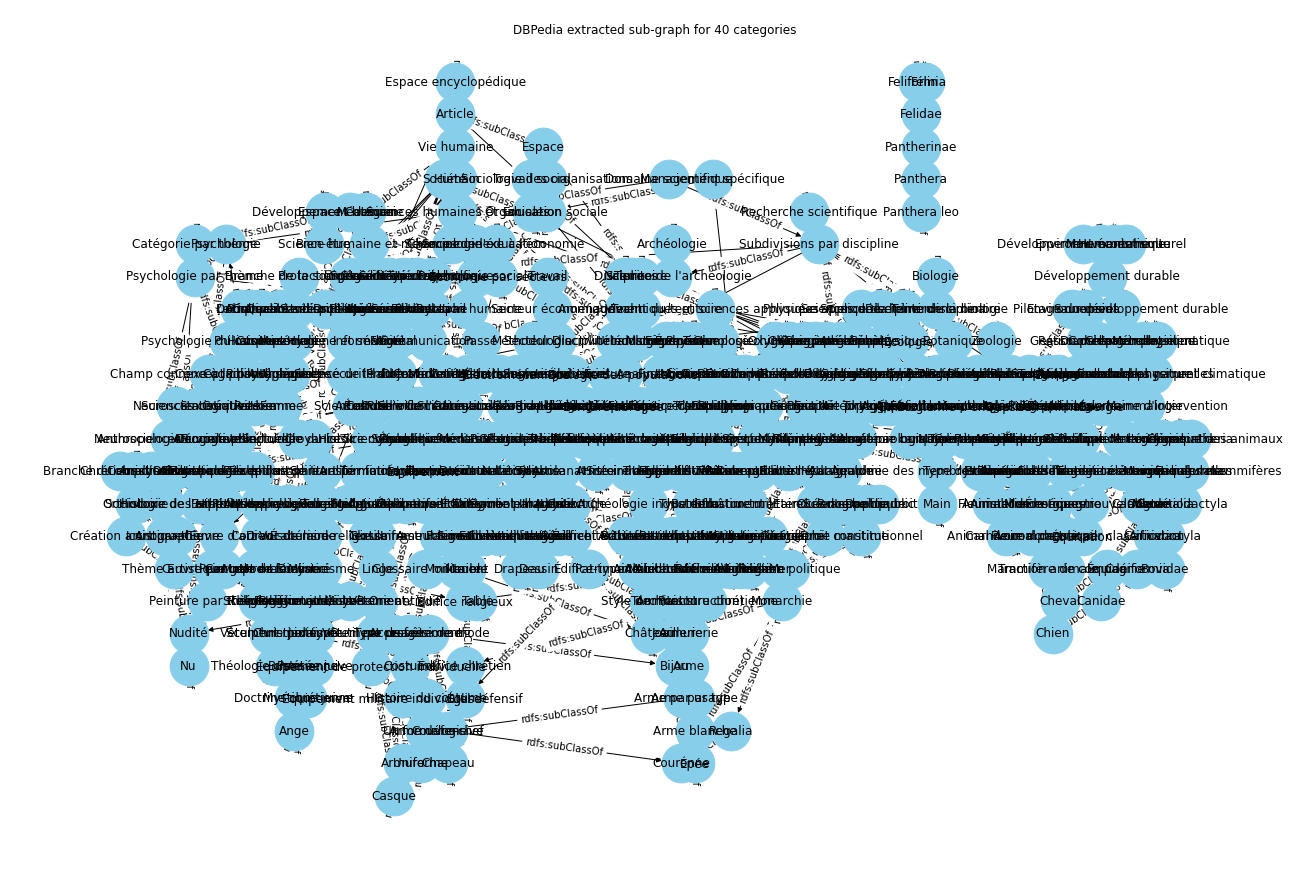

In [201]:
fig=plt.figure(figsize=(18, 12))

fig.suptitle('DBPedia extracted sub-graph for 40 categories')

# Build networkx graph
G=nx.from_pandas_edgelist(dbp_subgraph_df, 
                          'parent_category_label', 
                          'sub_category_label', 
                          edge_attr=True,
                          create_using=nx.DiGraph())

edge_labels = {(u,v) : 'rdfs:subClassOf' for u,v,d in G.edges(data=True)}

#pos = nx.shell_layout(G)

pos=graphviz_layout(G, prog='dot')

nx.draw(G, pos=pos,
        with_labels=True,
        node_size=1500,
        node_color='skyblue')#, node_shape="s", alpha=0.5)#, linewidths=20)

nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

plt.show()

In [202]:
print('DBPedia {0, %d}' % ancestor_depth)
print(nx.info(G))

DBPedia {0, 6}
Name: 
Type: DiGraph
Number of nodes: 498
Number of edges: 807
Average in degree:   1.6205
Average out degree:   1.6205


In [15]:
#sorted(dict(G.out_degree()))
sorted(dict(G.in_degree()).items(), key = lambda kv:(kv[1], kv[0]), reverse=False)

[('Accueil', 0),
 ('Activités en informatique', 0),
 ('Afrique', 0),
 ('Algorithmique', 0),
 ('Alimentation humaine', 0),
 ("Ancien empire d'Europe", 0),
 ('Ancien empire en Afrique', 0),
 ('Ancien empire en Asie', 0),
 ('Ancien pays', 0),
 ('Antiquité', 0),
 ('Art oratoire', 0),
 ("Art par forme d'expression et par période", 0),
 ("Association ou organisme lié à l'éducation", 0),
 ('Association ou organisme par secteur', 0),
 ('Catégorie par continent', 0),
 ('Catégorie par période', 0),
 ('Chimie du solide', 0),
 ('Chronologie de la littérature', 0),
 ('Civilisation antique', 0),
 ('Compétition', 0),
 ('Continent', 0),
 ('Culture occidentale', 0),
 ('Culture par période', 0),
 ("Discipline de l'astronomie", 0),
 ('Domaine de la géométrie', 0),
 ('Endocrinologie', 0),
 ('Eutheria', 0),
 ('Fondements des mathématiques', 0),
 ('Futur', 0),
 ('Gnathostome', 0),
 ("Géographie de l'Asie", 0),
 ('Géométrie euclidienne', 0),
 ('Hasard et aléatoire', 0),
 ('Histoire contemporaine', 0),
 ('His

In [67]:
#detect cycles
print( 'is acyclic? ', nx.is_directed_acyclic_graph(G))
print('Cycles:')
list(nx.find_cycle(G))

is acyclic?  False
Cycles:


[('Symbole', 'Dessin'), ('Dessin', 'Symbole')]

### Calculate similarity between two categories in the new DBPedia graph

In Corese there is a function that computes a semantic similarity between classes:

kg:similarity(?c1, ?c2)

The similarity is a number between 0 and 1

It is computed according to the length of the path between the two classes and by taking into account the depth of the classes where the length of an elementary step is 1/(2^n) where n is the depth in the hierarchy. That is, the deepest the most similar (the similarest :-))

Actually it works with classes and rdfs:subClassOf

It is based on Fabien's PhD thesis https://hal.inria.fr/inria-00070387/document (wrong link)

and described in the paper https://hal.inria.fr/inria-00070387/fr


In [297]:
query_dbp_similarity =  '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix ml: <http://ns.inria.fr/monalia/>
prefix xt: <http://ns.inria.fr/sparql-extension/>

select  *

where {

  graph ml:%s { 
       
     ?jcl_category_A  ml:label ?label_A;
                      skos:closeMatch ?dbp_category_A.

     ?jcl_category_B  ml:label ?label_B;
                      skos:closeMatch ?dbp_category_B.

      filter (?label_A != ?label_B)      
            
      bind(kg:similarity(?dbp_category_A, ?dbp_category_B) as ?similarity)
      #bind(str(?similarity) as ?similarity_str)
}
   
}
order by ?similarity

''' % (dbp_graph_name)

In [298]:
%time dbp_similarity_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_dbp_similarity)
print(dbp_similarity_df.shape)

dbp_similarity_df.similarity = dbp_similarity_df.similarity.str.replace(',', '.')
#dbp_similarity_df.similarity = dbp_similarity_df.similarity_str.replace(',', '.')
dbp_similarity_df = dbp_similarity_df.astype({'similarity': 'float' })


print(dbp_similarity_df.shape)

Wall time: 192 ms
(1332, 7)
(1332, 7)


In [205]:
#sanity test
dbp_similarity_df[(dbp_similarity_df.label_A == 'lion') & (dbp_similarity_df.label_B == 'fleur')]

,jcl_category_A,label_A,dbp_category_A,jcl_category_B,label_B,dbp_category_B,similarity
24,http://data.culture.fr/thesaurus/resource/ark:...,lion,http://fr.dbpedia.org/resource/Catégorie:Panth...,http://data.culture.fr/thesaurus/resource/ark:...,fleur,http://fr.dbpedia.org/resource/Catégorie:Fleur,0.000007


### Visualize DBPedia similarities 

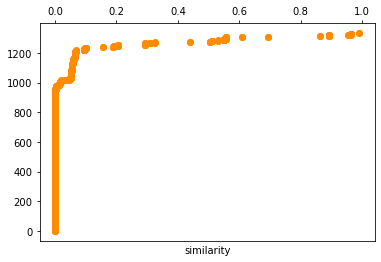

In [207]:
log_scale = False

if log_scale: 
    plt.scatter(x = np.log10(dbp_similarity_df.similarity),
            y = dbp_similarity_df.similarity.rank(method='first'),
            color='darkorange')
    plt.xlabel('log10(similarity)')
else:
    plt.scatter(x = dbp_similarity_df.similarity,
                y = dbp_similarity_df.similarity.rank(method='first'),
                color='darkorange')
    plt.xlabel('similarity')

In [208]:
similarity_matrix_dbp = dbp_similarity_df.pivot('label_A', 'label_B', 'similarity' ).fillna(0.0)#.astype('int32')

mask = similarity_matrix_dbp[similarity_matrix_dbp > 0]
mask = mask.isna()
#mask[np.triu_indices_from(mask)] = True

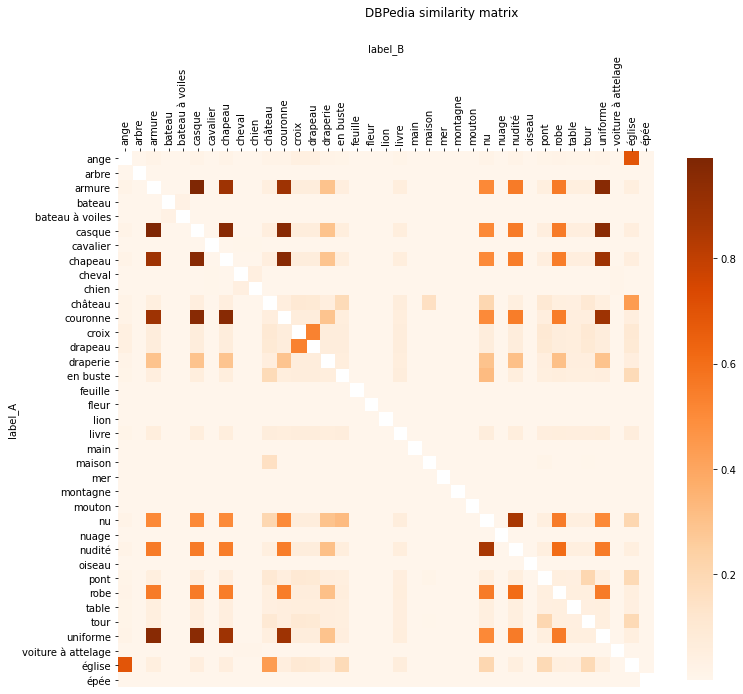

In [209]:
figure=plt.figure(figsize=(12, 12))

figure.suptitle('DBPedia similarity matrix')

ax = sns.heatmap(similarity_matrix_dbp, cmap='Oranges',  annot=False, square=True, mask=mask, cbar_kws={"shrink": 0.8})

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_ticks_position('top') # x axis on top
ax.xaxis.set_label_position('top') #axis lavel

C:\Users\abobashe\Anaconda3\lib\site-packages\seaborn\matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


<Figure size 864x864 with 0 Axes>

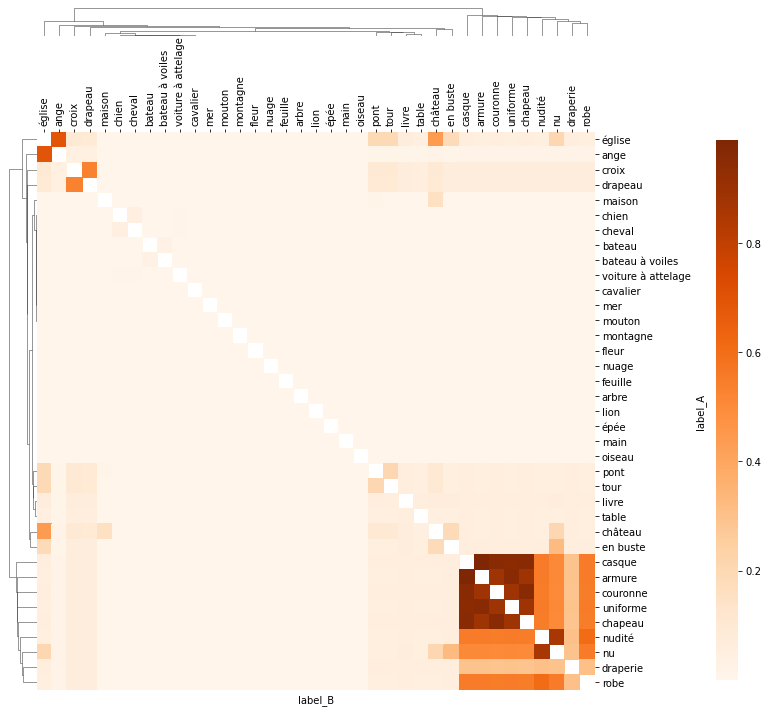

In [210]:
figure=plt.figure(figsize=(12, 12))

figure.suptitle('DBPedia clustermap')

sns.clustermap(similarity_matrix_dbp, cmap="Oranges",mask=mask,
               dendrogram_ratio=(0.05, 0.05),
               cbar_pos=(1, 0.05, .03, .75) )


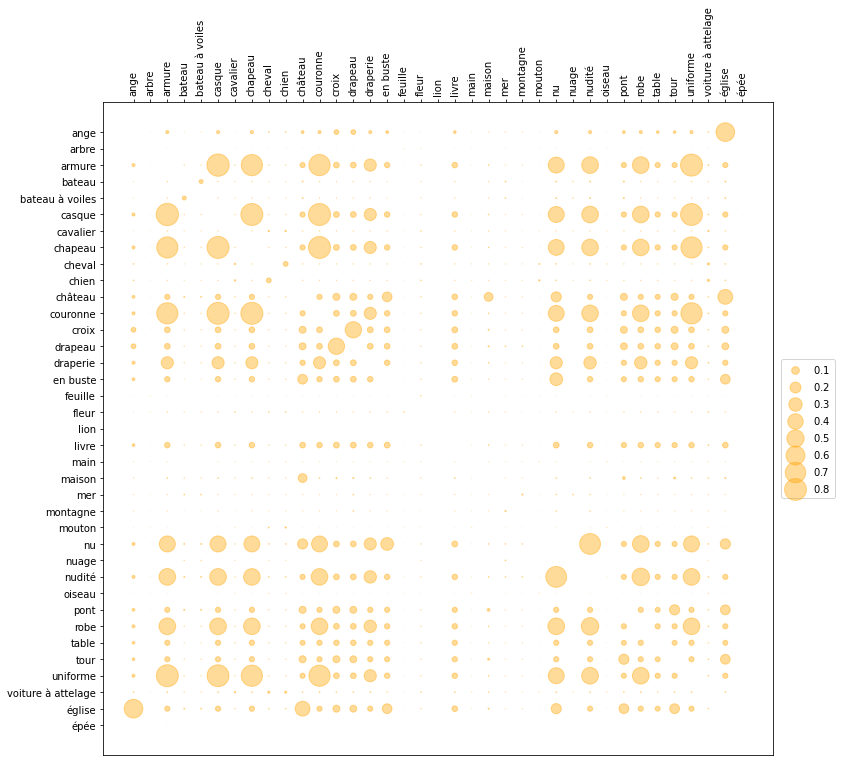

In [211]:
figure=plt.figure(figsize=(12, 12))

x = dbp_similarity_df.label_A
y = dbp_similarity_df.label_B

z = dbp_similarity_df.similarity

scale = True
zoom = 500
num_legend = 8
color = 'orange'

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

tick_labels = list(set(x).union(set(y)))
xticks_sorted = sorted(tick_labels, reverse=False)
x = [xticks_sorted.index(l) for l in x]

yticks_sorted = sorted(tick_labels, reverse=True)
y = [yticks_sorted.index(l) for l in y]

#scale z
if scale:
    z = ((z - z.min()) / (z.max()-z.min())) 
    #z = z.transform(np.exp)


plt.xticks(range(len(xticks_sorted)), xticks_sorted, rotation=90)
plt.yticks(range(len(yticks_sorted)), yticks_sorted)

scatter = plt.scatter(x, y, s=z, c=color, alpha=0.0, vmin=0.0, vmax=1.0) # hack to get the legend labels
_, labels = scatter.legend_elements(prop="sizes")
scatter = plt.scatter(x, y, s=z*zoom, c=color, alpha=0.4, vmin=0.0, vmax=1.0)

# produce a legend with a cross section of sizes from the scatter
handles, _ = scatter.legend_elements(prop="sizes", alpha=0.4, c=color)
plt.legend(handles, labels, loc="center right", bbox_to_anchor=(1.1,0.5))

plt.show()

### Load Garnier Thesaurus subgraph to CORESE server from the saved Turtle file

This section of the notebook reads subgraph of Garnier Thesaurus to calculate kg:similarity.

In [218]:
gt_graph_name = 'GT_unrooted'

In [219]:
read_saved_gt_graph = '''
prefix ml: <http://ns.inria.fr/monalia/>
prefix xt: <http://ns.inria.fr/sparql-extension/>

select *  where {
     bind (xt:load(<http://localhost:8080/data/similarity/%s.ttl>) as ?g)
     bind (xt:focus(?g, xt:sparql("select * where {}")) as ?sp)
     bind (xt:namedgraph(ml:%s, ?g) as ?t)
}
''' % (gt_graph_name, gt_graph_name)

In [220]:
%time metadata.sparql_service_update(wds_Joconde_Corese, read_saved_gt_graph)

Wall time: 33.1 ms


'Done'

### Query the Garnier Thesaurus subgraph

In [221]:
query_gt_subgraph = '''
prefix ml: <http://ns.inria.fr/monalia/>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 

select ?sub_category ?parent_category ?sub_category_label ?parent_category_label ?similarity
where {
     graph ml:%s {
       ?sub_category rdfs:subClassOf ?parent_category ;
                     skos:prefLabel ?sub_category_label.
       optional {?parent_category skos:prefLabel ?parent_category_label.}
       
       }
}
order by 
?sub_category ?parent_category
''' % (gt_graph_name)

In [222]:
%time gt_subgraph_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_gt_subgraph)
print(gt_subgraph_df.shape)

Wall time: 22 ms
(108, 5)


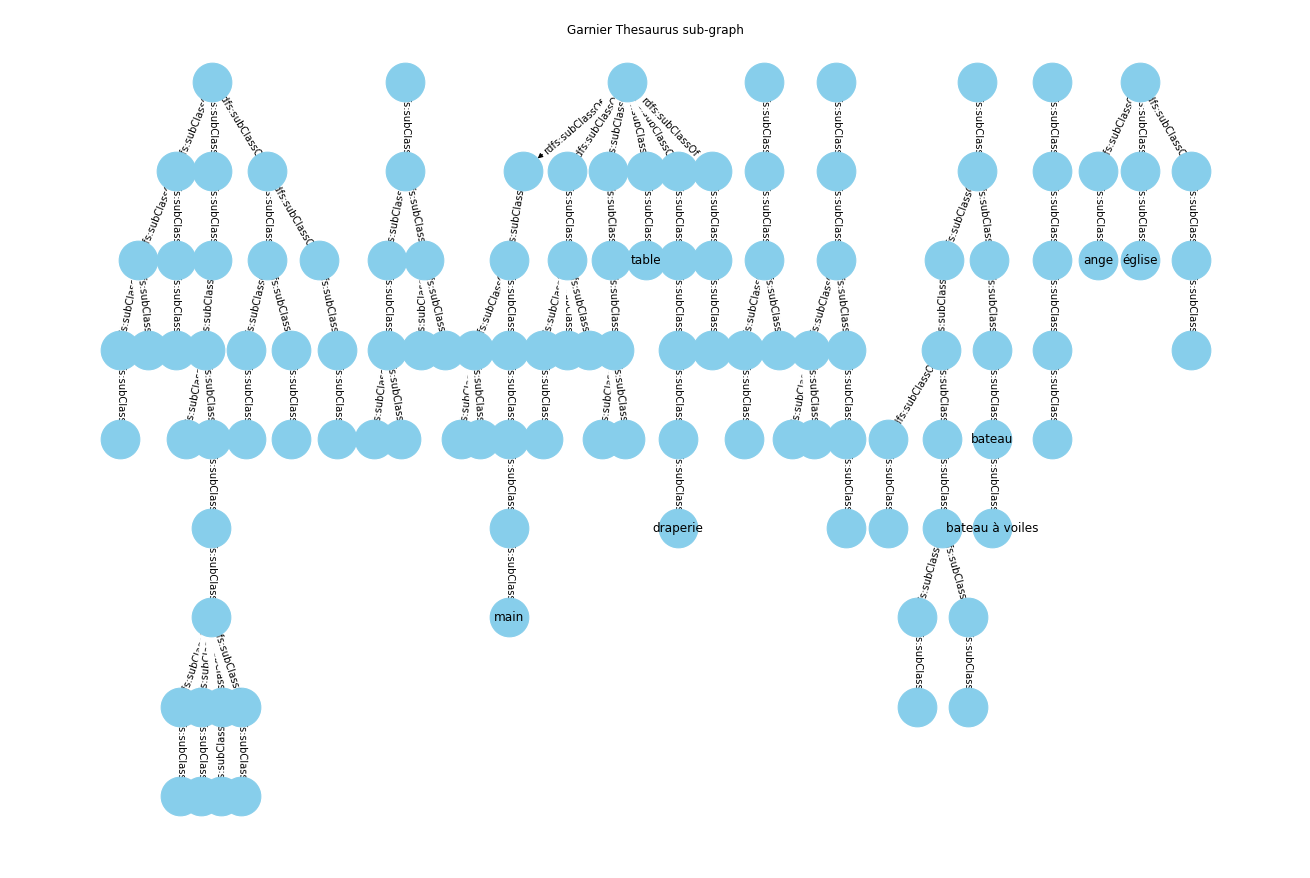

In [252]:
fig=plt.figure(figsize=(18, 12))

fig.suptitle('Garnier Thesaurus sub-graph')
# Build your graph

GT=nx.from_pandas_edgelist(gt_subgraph_df, 
                          'parent_category_label', 
                          'sub_category_label', 
                          edge_attr=True,
                          create_using=nx.DiGraph())

edge_labels = {(u,v) : 'rdfs:subClassOf' for u,v,d in GT.edges(data=True)}


#pos = nx.shell_layout(G)

pos=graphviz_layout(GT, prog='dot')

nx.draw(GT, pos=pos,
        with_labels=False,
        node_size=1500,
        node_color='skyblue')#, node_shape="s", alpha=0.5)#, linewidths=20)

nx.draw_networkx_edge_labels(GT,pos,edge_labels=edge_labels)


# to show only a few lables change the with_label = False above and uncomment the 2 line below with desired labels
lbls = {n:n if (n in ['bateau', 'bateau à voiles', 'main', 'draperie', 'ange', 'table', 'église']) else '' for n in pos }
nx.draw_networkx_labels(GT,pos,labels=lbls)

plt.show()

In [224]:
print('Granier Thesaurus graph')
print(nx.info(GT))

Granier Thesaurus graph
Name: 
Type: DiGraph
Number of nodes: 116
Number of edges: 108
Average in degree:   0.9310
Average out degree:   0.9310


In [225]:
query_gt_similarity =  '''
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix ml: <http://ns.inria.fr/monalia/>
prefix xt: <http://ns.inria.fr/sparql-extension/>

select  *

where {

  graph ml:%s { 
       
      ?jcl_category_A  ml:label ?label_A.

      ?jcl_category_B  ml:label ?label_B.

      filter (?label_A != ?label_B)      
            
      bind(kg:similarity(?jcl_category_A, ?jcl_category_B) as ?similarity)
      #bind(str(?similarity) as ?similarity_str)
}
   
}
order by ?similarity
''' % (gt_graph_name)

In [270]:
%time gt_similarity_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_gt_similarity)
print(gt_similarity_df.shape)

Wall time: 122 ms
(1560, 6)


In [271]:
gt_similarity_df.similarity = gt_similarity_df.similarity.str.replace(',', '.')
#gt_similarity_df.similarity = gt_similarity_df.similarity_str.replace(',', '.')
gt_similarity_df = gt_similarity_df.astype({'similarity': 'float' })

### Visualize Garnier Thesaurus similarities

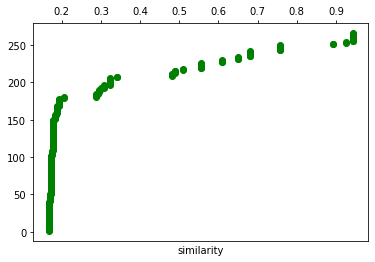

In [253]:
log_scale = False

if log_scale:
    plt.scatter(x = np.log10(gt_similarity_df.similarity),
                y = gt_similarity_df.similarity.rank(method='first'),
                color='green')
    plt.xlabel('log10(similarity)')
else:
    plt.scatter(x = gt_similarity_df.similarity,
                y = gt_similarity_df.similarity.rank(method='first'),
                color='green')
    plt.xlabel('similarity')

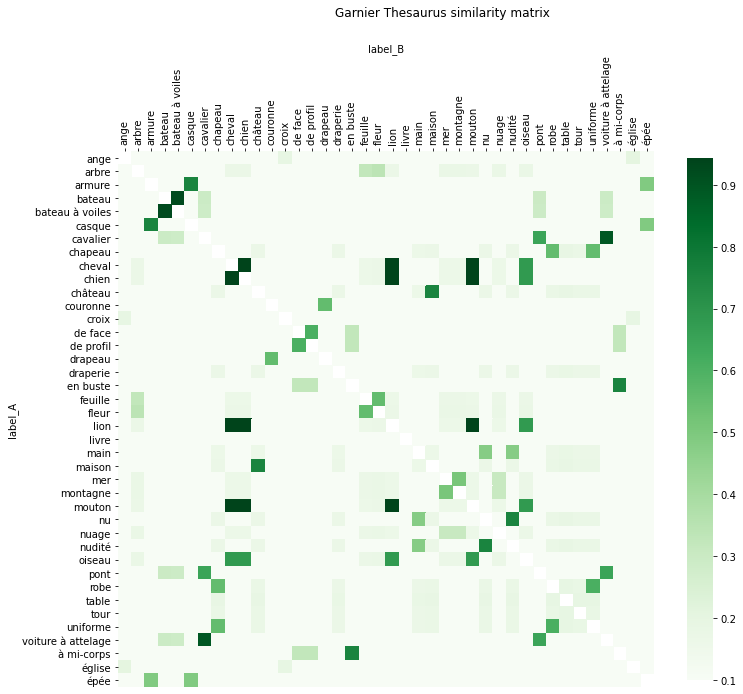

In [229]:
fig=plt.figure(figsize=(12, 12))

fig.suptitle('Garnier Thesaurus similarity matrix')

similarity_matrix_gt = gt_similarity_df.pivot('label_A', 'label_B', 'similarity' ).fillna(0.0)
mask = similarity_matrix_gt[similarity_matrix_gt > 0]
mask = mask.isna()
# Generate a mask for the upper triangle
#mask = mask | np.triu(np.ones_like(mask, dtype=np.bool))

ax = sns.heatmap(similarity_matrix_gt, cmap='Greens',  annot=False, square=True, mask=mask,
                 cbar_kws={"shrink": 0.8},
                 vmin=0.1 )

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_ticks_position('top') # x axis on top
ax.xaxis.set_label_position('top') #axis lavel

C:\Users\abobashe\Anaconda3\lib\site-packages\seaborn\matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


<Figure size 864x864 with 0 Axes>

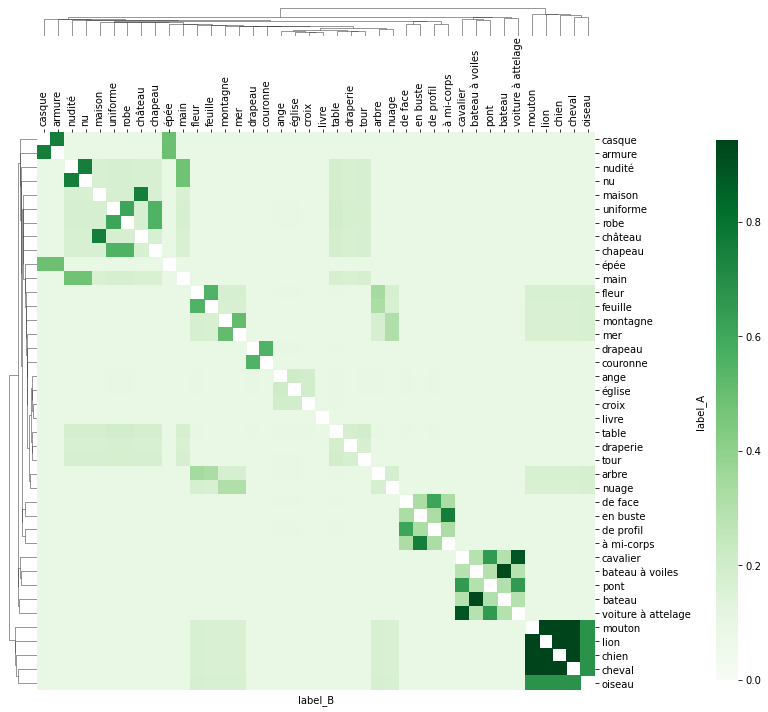

In [230]:
fig=plt.figure(figsize=(12, 12))

ax = sns.clustermap(similarity_matrix_gt, cmap="Greens", mask=mask,
               dendrogram_ratio=(0.05, 0.05),
               cbar_pos=(1, 0.05, .03, .75),
                   vmin=0.0)

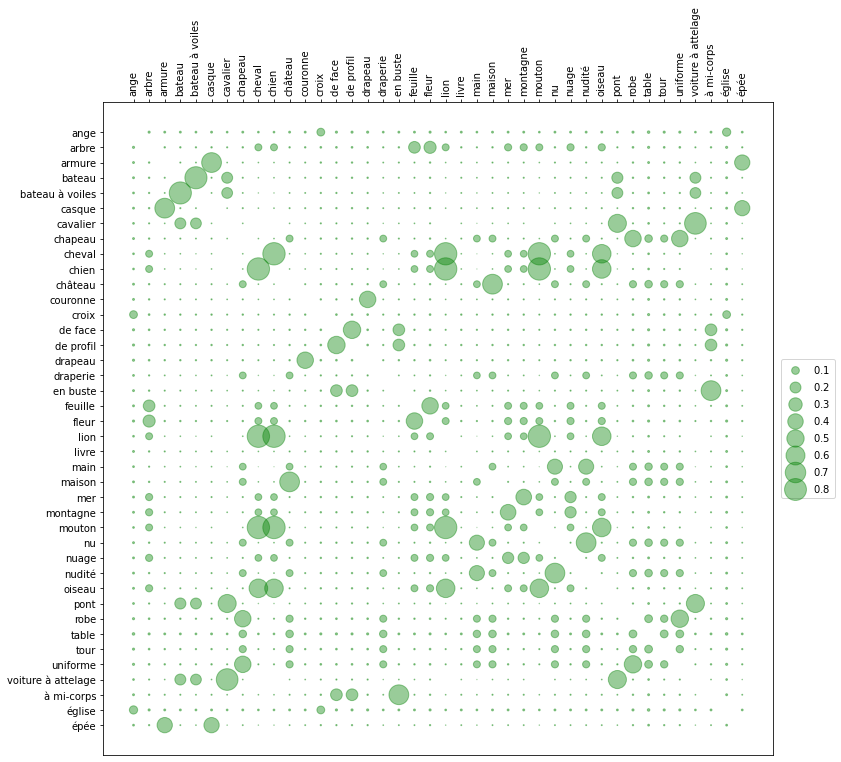

In [231]:
figure=plt.figure(figsize=(12, 12))

x = gt_similarity_df.label_A
y = gt_similarity_df.label_B

z = gt_similarity_df.similarity

scale = True
zoom = 500
num_legend = 8
color = 'green'

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

tick_labels = list(set(x).union(set(y)))
xticks_sorted = sorted(tick_labels, reverse=False)
x = [xticks_sorted.index(l) for l in x]

yticks_sorted = sorted(tick_labels, reverse=True)
y = [yticks_sorted.index(l) for l in y]

#scale z
if scale:
    z = ((z - z.min()) / (z.max()-z.min())) 
    #z = z.transform(np.exp)


plt.xticks(range(len(xticks_sorted)), xticks_sorted, rotation=90)
plt.yticks(range(len(yticks_sorted)), yticks_sorted)

scatter = plt.scatter(x, y, s=z, c=color, alpha=0.0) # hack to get the legend labels
_, labels = scatter.legend_elements(prop="sizes")
scatter = plt.scatter(x, y, s=z*zoom, c=color, alpha=0.4)

# produce a legend with a cross section of sizes from the scatter
handles, _ = scatter.legend_elements(prop="sizes", alpha=0.4, c=color)
plt.legend(handles, labels, loc="center right", bbox_to_anchor=(1.1,0.5))

plt.show()

# Merge similarity data of both graphs and analyse the difference

In [232]:
similarity_df = gt_similarity_df.merge(dbp_similarity_df,
                                        left_on=['label_A', 'label_B'], 
                                        right_on=['label_A', 'label_B'],    
                                        how='left',
                                        suffixes=('_GT', '_DBP'))

similarity_df['diff'] = similarity_df.similarity_GT - similarity_df.similarity_DBP

In [284]:
#run this code to make small similarity 0 to emulate unconnected categories
#0.105 is empirical threshold based on Garnier thesaurus analysis
similarity_df.similarity_GT = similarity_df.similarity_GT.apply(lambda x: 0.0 if x < 0.105 else x)
similarity_df.similarity_DBP = similarity_df.similarity_DBP.apply(lambda x: 0.0 if x < 0.105 else x)
similarity_df['diff'] = similarity_df.similarity_GT - similarity_df.similarity_DBP

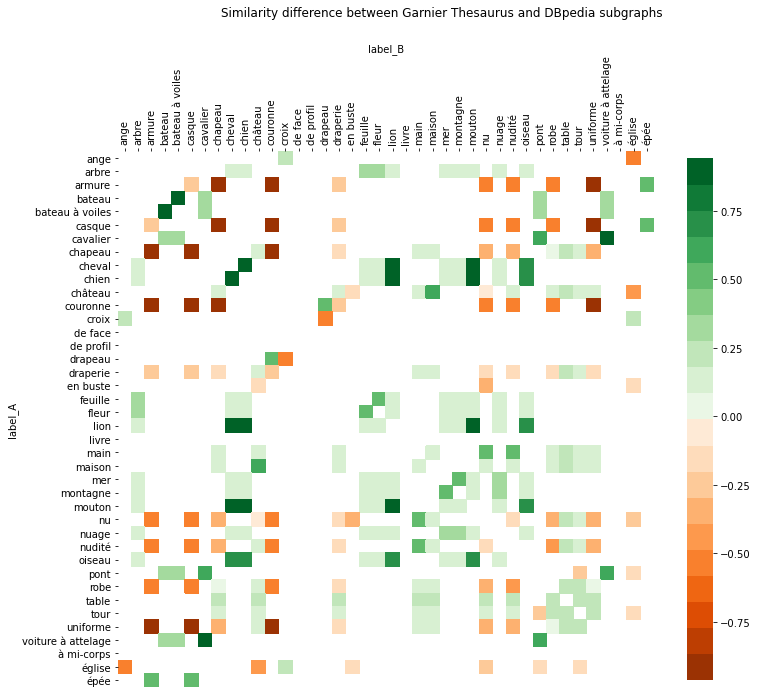

In [285]:
fig=plt.figure(figsize=(12, 12))

fig.suptitle('Similarity difference between Garnier Thesaurus and DBpedia subgraphs')

similarity_matrix_diff = similarity_df.pivot('label_A', 'label_B', 'diff' ).fillna(0.0)
mask = similarity_matrix_diff[similarity_matrix_diff != 0.0]
mask = mask.isna()
# Generate a mask for the upper triangle
#mask = mask | np.triu(np.ones_like(mask, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(22, 130, s=99, n=16, as_cmap=True)
my_pal =  sns.color_palette('Oranges_r', 10) + sns.color_palette('Greens', 10)

ax = sns.heatmap(similarity_matrix_diff, cmap=my_pal,  annot=False, square=True, mask=mask, cbar_kws={"shrink": 0.8})

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_ticks_position('top') # x axis on top
ax.xaxis.set_label_position('top') #axis lavel


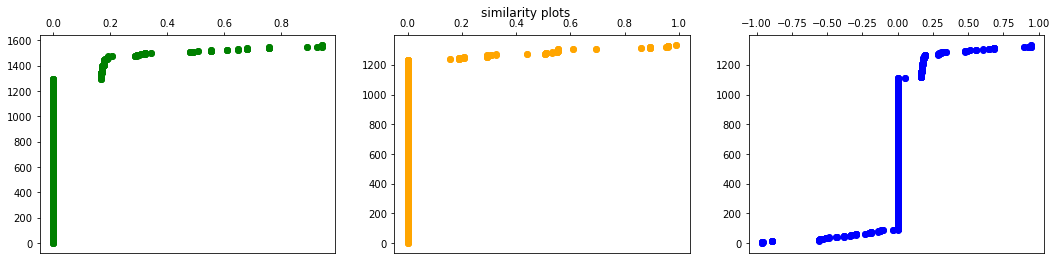

In [286]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches((18, 4))

fig.suptitle('similarity plots')

ax1.scatter(x = similarity_df['similarity_GT'],
            y = similarity_df['similarity_GT'].rank(method='first'),
            color='green')

ax2.scatter(x = similarity_df['similarity_DBP'],
            y = similarity_df['similarity_DBP'].rank(method='first'),
            color='orange')

ax3.scatter(x = similarity_df['diff'],
            y = similarity_df['diff'].rank(method='first'),
            color='blue')


### Visualize difference
https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/scatter_with_legend.html

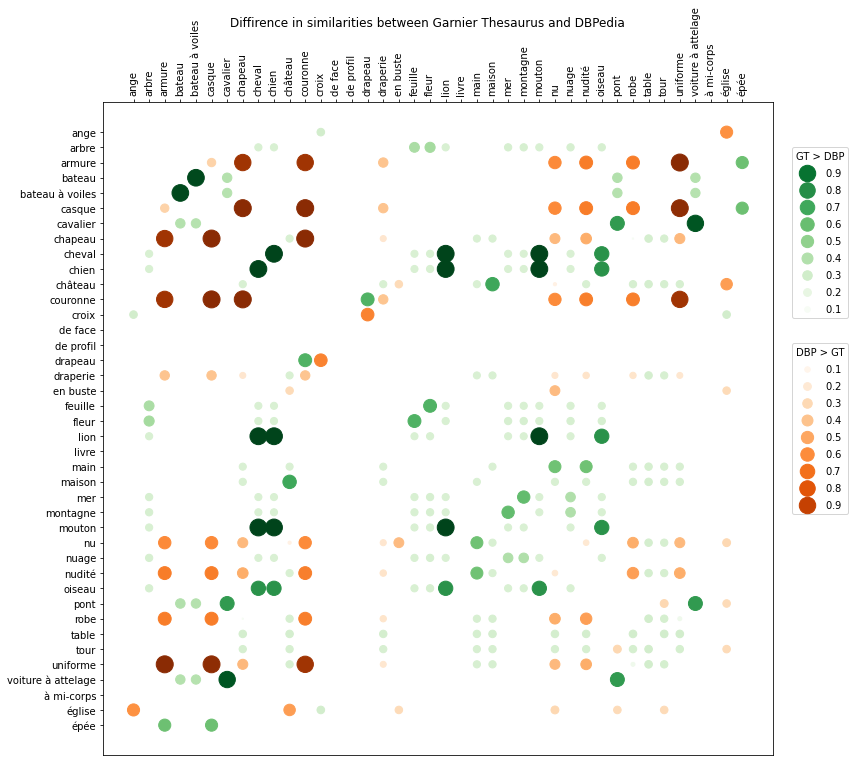

In [287]:
figure=plt.figure(figsize=(12, 12))

figure.suptitle('Diffirence in similarities between Garnier Thesaurus and DBPedia')

x = similarity_df.label_A
y = similarity_df.label_B

z = similarity_df['diff']
z_gt = z.apply(lambda x: x if x > 0 else 0.0)
z_dbp = z.apply(lambda x: -x if x < 0 else 0.0)

scale = False
zoom = 300
num_legend = 8

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

tick_labels = list(set(x).union(set(y)))
xticks_sorted = sorted(tick_labels, reverse=False)
x = [xticks_sorted.index(l) for l in x]

yticks_sorted = sorted(tick_labels, reverse=True)
y = [yticks_sorted.index(l) for l in y]

#scale z
if scale:
    z_gt = ((z_gt - z_gt.min()) / (z_gt.max()-z_gt.min())) 
    z_dbp = ((z_dbp - z_dbp.min()) / (z_dbp.max()-z_dbp.min())) 
    #z = z.transform(np.exp)

plt.xticks(range(len(xticks_sorted)), xticks_sorted, rotation=90)
plt.yticks(range(len(yticks_sorted)), yticks_sorted)

# plot GT
#######################################################################################################
scatter = plt.scatter(x, y, s=z_gt*zoom, c=z_gt, cmap="Greens", alpha=1.0)#, vmin=0.0, vmax=1.0)

# create better legend
handles_gt_color, _ = scatter.legend_elements(prop="colors", num=num_legend)
handles_gt_size , labels_gt = scatter.legend_elements(prop="sizes", num=num_legend, func=(lambda x: x /zoom ))

#combine color and size in one legend
for i, h in enumerate(handles_gt_size):
    h.set_color(handles_gt_color[i].get_color())

#reverse legend for a divergence effect
handles_gt_size.reverse()
labels_gt.reverse()

ax = figure.axes[0]
legend_gt = ax.legend(handles_gt_size, labels_gt, loc="center right", title='GT > DBP', bbox_to_anchor=(1.12,0.8))
ax.add_artist(legend_gt)

# plot DBP
########################################################################################################

scatter = ax.scatter(x, y, s=z_dbp*zoom, c=z_dbp, cmap="Oranges", alpha=1.0, vmin=0.0, vmax=1.0)
handles_dbp_color, _ = scatter.legend_elements(prop="colors", num=num_legend)
handles_dbp_size , labels_dbp = scatter.legend_elements(prop="sizes", num=num_legend, func=(lambda x: x /zoom ))

#combine color and size in one legend
for i, h in enumerate(handles_dbp_size):
    h.set_color(handles_dbp_color[i].get_color())

legend_dbp = ax.legend(handles_dbp_size, labels_dbp, loc="center right", title='DBP > GT', bbox_to_anchor=(1.12,0.5))

plt.show()

### Get top 5 largest diffrences

In [289]:
if ('pair' not in similarity_df.columns):
    similarity_df.insert(0, 'pair', 
                         similarity_df.apply(lambda row: '(%s, %s)' % (row.label_A,  row.label_B),  axis=1))
    similarity_df.insert(1, 'pair_odr',
                         similarity_df.apply(lambda row: '(%s, %s)' % tuple(sorted((row.label_A,  row.label_B))),  axis=1))

# To get top 5 highest differences on GT side set ascending= False
#                                     DBPedia side set ascending= True                      
similarity_df.loc[:, ['pair', 'pair_odr', 'similarity_GT', 'similarity_DBP', 'diff' ]] \
              .drop_duplicates(subset=['diff', 'pair_odr']) \
              .sort_values(by=['diff', 'pair_odr'], ascending= False) \
              .head(5).pair_odr

1556      (lion, mouton)
1550     (chien, mouton)
1549       (chien, lion)
1553    (cheval, mouton)
1552      (cheval, lion)
Name: pair_odr, dtype: object

## Scrapbook